In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
from google.colab import files
upload = files.upload()

Saving globalpowerplantdatabasev130.zip to globalpowerplantdatabasev130 (2).zip


In [61]:
import zipfile
import os

zip_path = "/content/globalpowerplantdatabasev130.zip"  # your zip file

# Create a folder to extract into
extract_folder = "/content/globalpowerplantdatabasev130"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Check extracted files
print(os.listdir(extract_folder))


['global_power_plant_database.csv', 'README.txt', 'RELEASE_NOTES.txt', 'A_Global_Database_of_Power_Plants.pdf', 'Estimating_Power_Plant_Generation_in_the_Global_Power_Plant_Database.pdf']


In [62]:
df = pd.read_csv("/content/globalpowerplantdatabasev130/global_power_plant_database.csv", low_memory=False)
print(df.isnull().sum())

country                               0
country_long                          0
name                                  0
gppd_idnr                             0
capacity_mw                           0
latitude                              0
longitude                             0
primary_fuel                          0
other_fuel1                       32992
other_fuel2                       34660
other_fuel3                       34844
commissioning_year                17489
owner                             14068
source                               15
url                                  18
geolocation_source                  419
wepp_id                           18702
year_of_capacity_data             20049
generation_gwh_2013               28519
generation_gwh_2014               27710
generation_gwh_2015               26733
generation_gwh_2016               25792
generation_gwh_2017               25436
generation_gwh_2018               25299
generation_gwh_2019               25277


In [63]:
# Drop other_fuel

for col in ["other_fuel", "other_fuel2", "other_fuel3"]:
  if col in df.columns:
    df = df.drop(columns = [col])

# Fill text with with unknown
for col in ["owner", "source", "url", "geolocation_source", "generation_data_source"]:
  if col in df.columns:
    df[col] = df[col].astype("string").fillna("unknown")

# Numeric coercions (keep NaN)

for col in ["capacity_mw", "latitude", "longitude"]:
  if col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

gen_cols = [c for c in df.columns if c.startswith("generation_gwh_")]
est_cols = [c for c in df.columns if c.startswith("estimated_generation_gwh_")]
for c in gen_cols + est_cols:
  df[c] = pd.to_numeric(df[c], errors="coerce")

# 4) Clean year columns: convert to proper integers, but still allow missing values
for year_col in ["commissing_year", "year_of_capacity_data"]:
  if year_col in df.columns:
    ser = pd.to_numeric(df[year_col], errors="coerce")
    df[year_col] = ser.round().astype("Int64")


# Save
df.to_csv("global_power_plant_database_CLEANED.csv", index=False)


In [64]:
df = pd.read_csv("/content/global_power_plant_database_CLEANED.csv")

nums_cols = df.select_dtypes(include=["number"]).columns

summary = pd.DataFrame({
    "mean": df[nums_cols].mean(),
    "median": df[nums_cols].median(),
    "std": df[nums_cols].std(),
}).round(2)

print("Numeric Summary")
print(summary)


Numeric Summary
                                  mean   median      std
capacity_mw                     163.36    16.74   489.64
latitude                         32.82    39.73    22.64
longitude                        -6.97    -2.13    78.41
commissioning_year             1997.41  2007.00    23.40
year_of_capacity_data          2018.22  2019.00     1.61
generation_gwh_2013             592.70    23.43  2174.83
generation_gwh_2014             656.86    23.61  2231.46
generation_gwh_2015             762.37    26.14  2533.46
generation_gwh_2016             693.15    22.46  2404.52
generation_gwh_2017             661.83    17.88  2369.30
generation_gwh_2018             517.32    12.53  1975.30
generation_gwh_2019             423.92    11.53  1698.51
estimated_generation_gwh_2013   239.11    27.62  1191.26
estimated_generation_gwh_2014   242.43    28.25  1285.80
estimated_generation_gwh_2015   235.87    26.83  1267.01
estimated_generation_gwh_2016   235.70    27.56  1259.56
estimated_gener

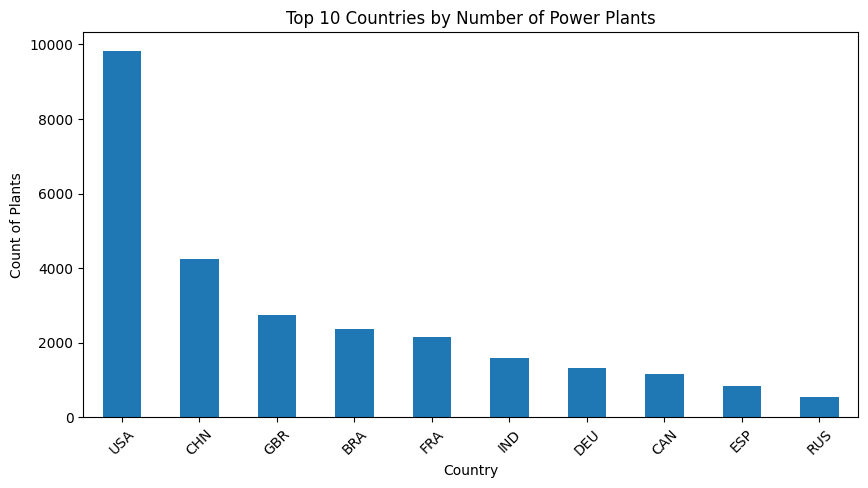

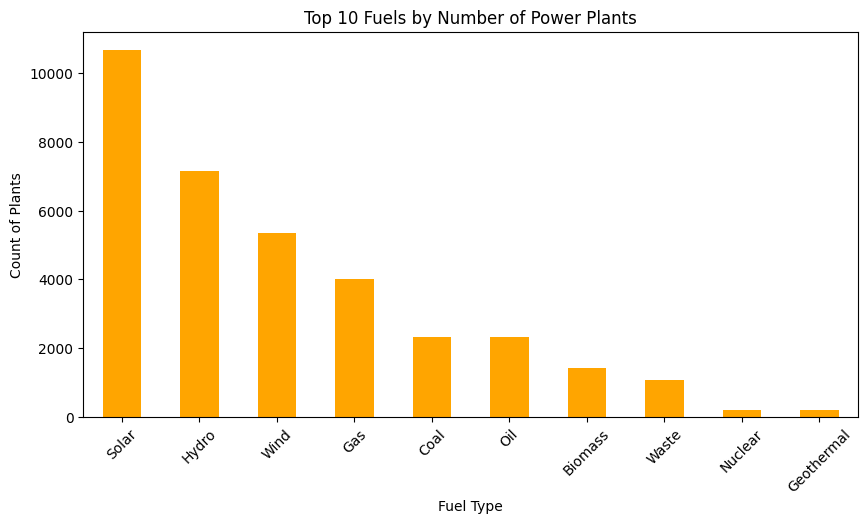

In [65]:
# Top 10 countries by plant count
country_counts = df["country"].value_counts().head(10)

plt.figure(figsize=(10,5))
country_counts.plot(kind="bar")
plt.title("Top 10 Countries by Number of Power Plants")
plt.xlabel("Country")
plt.ylabel("Count of Plants")
plt.xticks(rotation=45)
plt.show()

# Top 10 fuels by plant count
fuel_counts = df["primary_fuel"].value_counts().head(10)

plt.figure(figsize=(10,5))
fuel_counts.plot(kind="bar", color="orange")
plt.title("Top 10 Fuels by Number of Power Plants")
plt.xlabel("Fuel Type")
plt.ylabel("Count of Plants")
plt.xticks(rotation=45)
plt.show()

In [66]:
# Pick the top fuels to analyze
top_fuels = df["primary_fuel"].value_counts().head(6).index.tolist()
print(top_fuels)

# Dictionary: fuel -> array of capacities
cap_by_fuel = {f: df.loc[df["primary_fuel"] == f, "capacity_mw"].dropna().to_numpy()
               for f in top_fuels}

# Calculate stats with NumPy
for fuel, arr in cap_by_fuel.items():
    print(f"\nFuel type: {fuel}")
    print(f"Count: {len(arr)}")
    print(f"Mean capacity: {np.mean(arr):.2f} MW")
    print(f"Median capacity: {np.median(arr):.2f} MW")
    print(f"Std dev capacity: {np.std(arr, ddof=1):.2f} MW")


['Solar', 'Hydro', 'Wind', 'Gas', 'Coal', 'Oil']

Fuel type: Solar
Count: 10665
Mean capacity: 17.66 MW
Median capacity: 5.80 MW
Std dev capacity: 41.94 MW

Fuel type: Hydro
Count: 7156
Mean capacity: 147.17 MW
Median capacity: 20.00 MW
Std dev capacity: 549.81 MW

Fuel type: Wind
Count: 5344
Mean capacity: 49.22 MW
Median capacity: 27.00 MW
Std dev capacity: 106.14 MW

Fuel type: Gas
Count: 3998
Mean capacity: 373.45 MW
Median capacity: 147.50 MW
Std dev capacity: 560.93 MW

Fuel type: Coal
Count: 2330
Mean capacity: 843.58 MW
Median capacity: 600.00 MW
Std dev capacity: 888.19 MW

Fuel type: Oil
Count: 2320
Mean capacity: 112.88 MW
Median capacity: 9.00 MW
Std dev capacity: 392.01 MW


In [67]:
from scipy import stats

# Compare two fuel types
f1, f2 = top_fuels[0], top_fuels[1]
x, y = cap_by_fuel[f1], cap_by_fuel[f2]

t_stat, p_val = stats.ttest_ind(x, y, equal_var=False)  # Welch’s t-test
print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.4f}")
if p_val < 0.05:
    print("Reject H₀: means differ")
else:
    print("Fail to reject H₀: no evidence of difference")


t-statistic = -19.888, p-value = 0.0000
Reject H₀: means differ


In [68]:
# Converting commissioning_year to numeric (some may be NaN or invalid)
years = pd.to_numeric(df["commissioning_year"], errors="coerce").dropna().astype(int)

# Counting plants commissioned per year
plants_per_year = years.value_counts().sort_index()

print("=== Plants commissioned per year (first 15 years) ===")
print(plants_per_year.head(15))
print("\n=== Plants commissioned per year (last 15 years) ===")
print(plants_per_year.tail(15))

# NumPy quick stats
print("\nEarliest year:", np.min(years))
print("Latest year:", np.max(years))
print("Average commissioning year:", np.mean(years).round(1))


=== Plants commissioned per year (first 15 years) ===
commissioning_year
1896     1
1899     1
1900     6
1901     2
1902     4
1903     6
1904     3
1905     9
1906     7
1907    13
1908     9
1909     9
1910    12
1911     8
1912    20
Name: count, dtype: int64

=== Plants commissioned per year (last 15 years) ===
commissioning_year
2006    406
2007    392
2008    487
2009    568
2010    556
2011    617
2012    769
2013    688
2014    823
2015    821
2016    880
2017    782
2018    617
2019    599
2020    150
Name: count, dtype: int64

Earliest year: 1896
Latest year: 2020
Average commissioning year: 1997.4


In [69]:
# Drop missing years
df_year_fuel = df.dropna(subset=["commissioning_year"])

# Keep year as int
df_year_fuel["commissioning_year"] = df_year_fuel["commissioning_year"].astype(int)

# Group by year and fuel type
fuel_year_counts = df_year_fuel.groupby(["commissioning_year", "primary_fuel"]).size().unstack(fill_value=0)

# Calculate share per year
fuel_year_share = fuel_year_counts.div(fuel_year_counts.sum(axis=1), axis=0)

print("=== Fuel mix (first 10 years in dataset) ===")
print(fuel_year_share.head(10).round(2))

print("\n=== Fuel mix (last 10 years in dataset) ===")
print(fuel_year_share.tail(10).round(2))


=== Fuel mix (first 10 years in dataset) ===
primary_fuel        Biomass  Coal  Cogeneration   Gas  Geothermal  Hydro  \
commissioning_year                                                         
1896                   0.00   0.0           0.0  0.00         0.0   1.00   
1899                   0.00   0.0           0.0  0.00         0.0   1.00   
1900                   0.00   0.0           0.0  0.17         0.0   0.50   
1901                   0.00   0.0           0.0  0.00         0.0   1.00   
1902                   0.00   0.0           0.0  0.00         0.0   1.00   
1903                   0.00   0.0           0.0  0.00         0.0   1.00   
1904                   0.00   0.0           0.0  0.00         0.0   1.00   
1905                   0.11   0.0           0.0  0.00         0.0   0.78   
1906                   0.00   0.0           0.0  0.00         0.0   1.00   
1907                   0.00   0.0           0.0  0.00         0.0   1.00   

primary_fuel        Nuclear   Oil  Other  

/tmp/ipython-input-1155437490.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year_fuel["commissioning_year"] = df_year_fuel["commissioning_year"].astype(int)


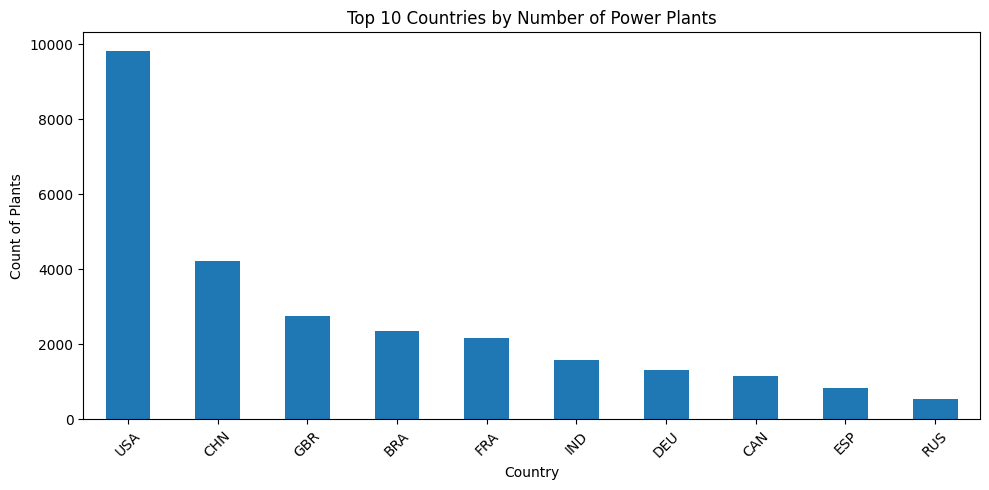

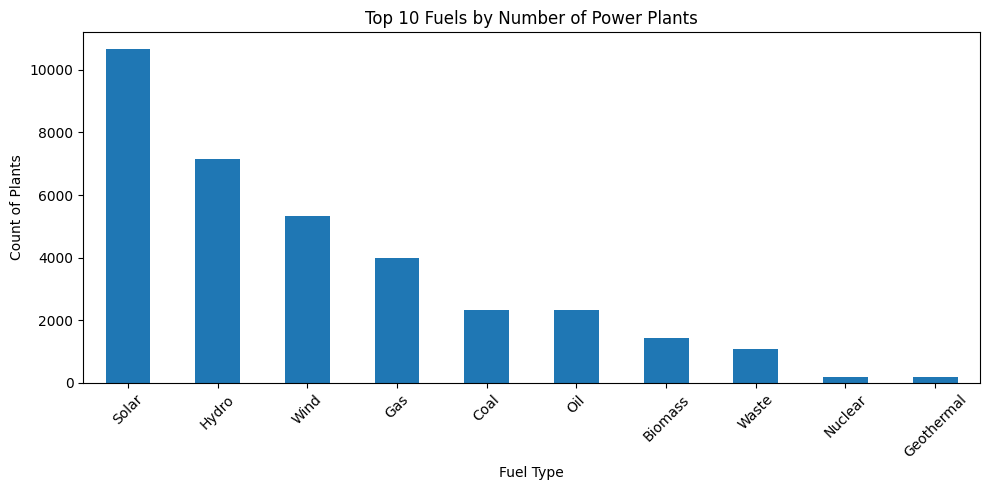

In [70]:
# Top 10 countries by plant count
country_counts = df["country"].value_counts().head(10)

plt.figure(figsize=(10,5))
country_counts.plot(kind="bar")
plt.title("Top 10 Countries by Number of Power Plants")
plt.xlabel("Country")
plt.ylabel("Count of Plants")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 fuels by plant count
fuel_counts = df["primary_fuel"].value_counts().head(10)

plt.figure(figsize=(10,5))
fuel_counts.plot(kind="bar")
plt.title("Top 10 Fuels by Number of Power Plants")
plt.xlabel("Fuel Type")
plt.ylabel("Count of Plants")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


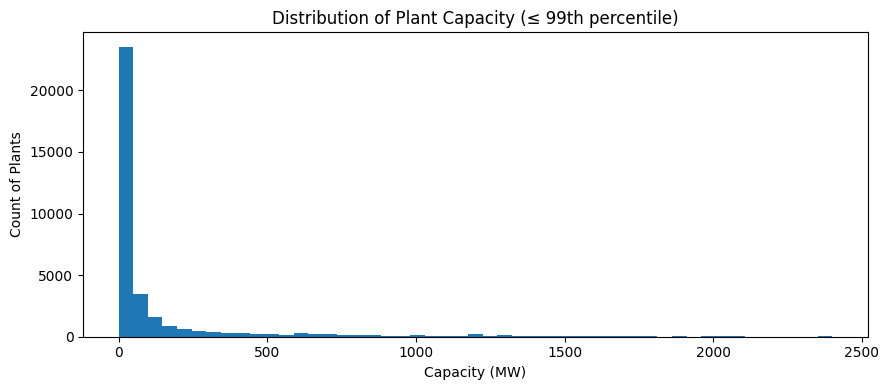

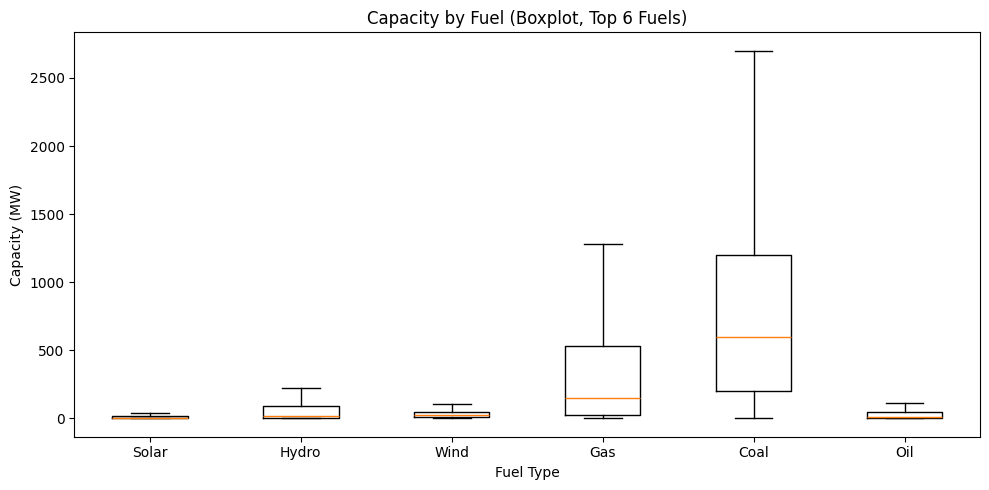

In [71]:
vals = df["capacity_mw"].dropna().to_numpy()

# Histogram (trim extreme tail at 99th percentile to see shape)
upper = np.nanpercentile(vals, 99)
bins = np.linspace(0, upper, 50)

plt.figure(figsize=(9,4))
plt.hist(vals[vals <= upper], bins=bins)
plt.title("Distribution of Plant Capacity (≤ 99th percentile)")
plt.xlabel("Capacity (MW)")
plt.ylabel("Count of Plants")
plt.tight_layout()
plt.show()

# Boxplot by fuel (top 6 fuels)
top_fuels = df["primary_fuel"].value_counts().head(6).index.tolist()
data = [df.loc[df["primary_fuel"] == f, "capacity_mw"].dropna().to_numpy() for f in top_fuels]

plt.figure(figsize=(10,5))
plt.boxplot(data, showfliers=False)  # hide extreme outliers for readability
plt.title("Capacity by Fuel (Boxplot, Top 6 Fuels)")
plt.xlabel("Fuel Type")
plt.ylabel("Capacity (MW)")
plt.xticks(ticks=range(1, len(top_fuels)+1), labels=top_fuels, rotation=0)
plt.tight_layout()
plt.show()


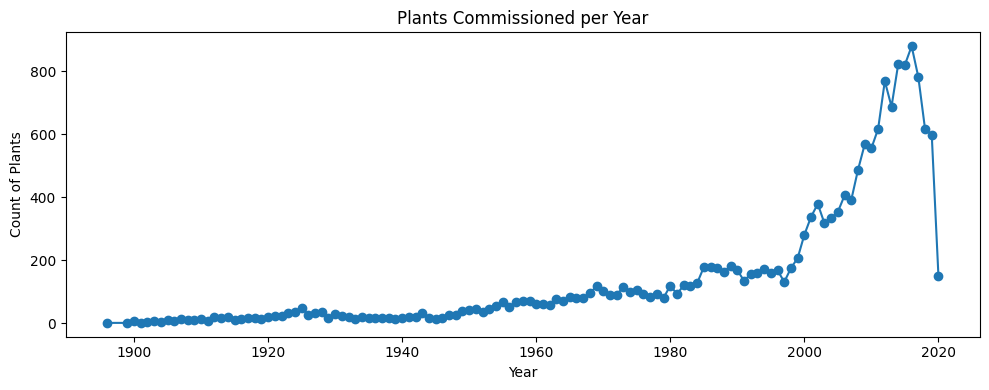

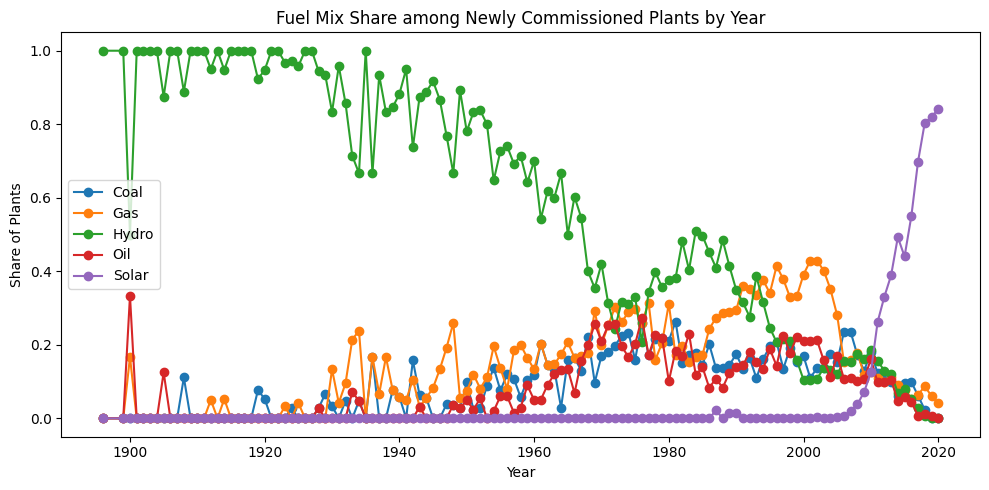

In [72]:
# A) Counts per year
years = pd.to_numeric(df["commissioning_year"], errors="coerce").dropna().astype(int)
plants_per_year = years.value_counts().sort_index()

plt.figure(figsize=(10,4))
plt.plot(plants_per_year.index, plants_per_year.values, marker="o")
plt.title("Plants Commissioned per Year")
plt.xlabel("Year")
plt.ylabel("Count of Plants")
plt.tight_layout()
plt.show()

# B) Fuel mix share among newly commissioned plants (top 5 fuels)
mix = (
    df.dropna(subset=["commissioning_year"])
      .assign(commissioning_year=lambda d: d["commissioning_year"].astype(int))
      .loc[df["primary_fuel"].isin(top_fuels), ["commissioning_year","primary_fuel"]]
      .groupby(["commissioning_year","primary_fuel"]).size()
      .unstack(fill_value=0)
)
mix_share = mix.div(mix.sum(axis=1), axis=0)

plt.figure(figsize=(10,5))
for fuel in mix_share.columns[:5]:
    plt.plot(mix_share.index, mix_share[fuel], marker="o", label=fuel)
plt.title("Fuel Mix Share among Newly Commissioned Plants by Year")
plt.xlabel("Year")
plt.ylabel("Share of Plants")
plt.legend()
plt.tight_layout()
plt.show()


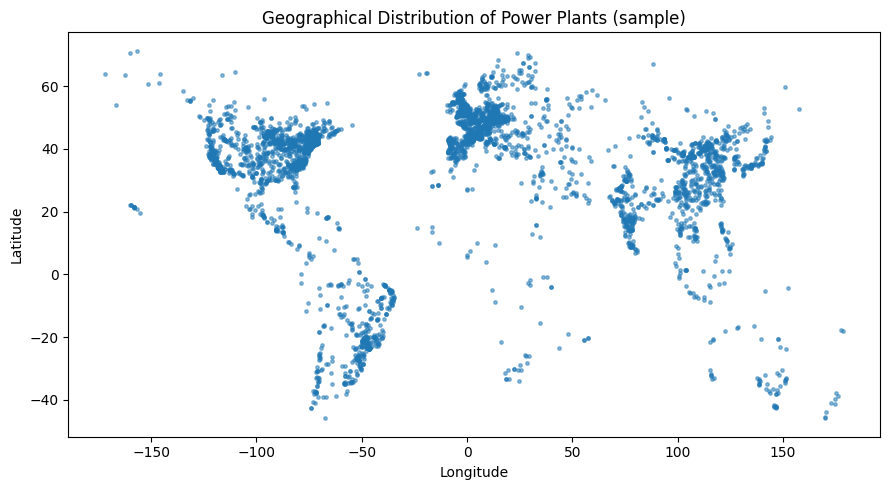

In [73]:
import matplotlib.pyplot as plt

geo = df.dropna(subset=["latitude","longitude"])
# sample to avoid overplotting (optional)
geo_sample = geo.sample(n=min(4000, len(geo)), random_state=42)

plt.figure(figsize=(9,5))
plt.scatter(geo_sample["longitude"], geo_sample["latitude"], s=6, alpha=0.5)
plt.title("Geographical Distribution of Power Plants (sample)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


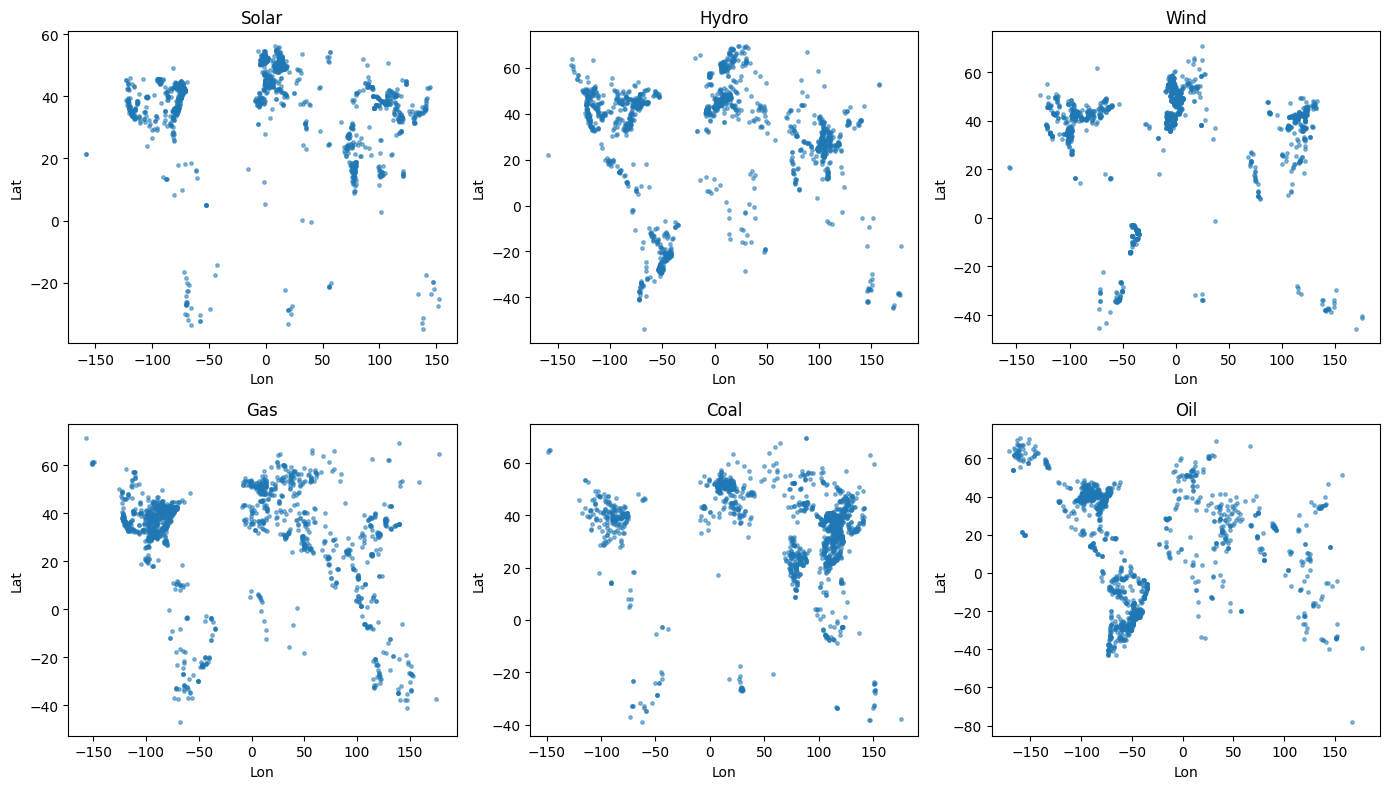

In [74]:
import math
fuels_to_show = df["primary_fuel"].value_counts().head(6).index.tolist()
rows = math.ceil(len(fuels_to_show)/3)
cols = 3

plt.figure(figsize=(14, 8))
for i, fuel in enumerate(fuels_to_show, 1):
    sub = df[df["primary_fuel"] == fuel].dropna(subset=["latitude","longitude"])
    sub = sub.sample(n=min(1500, len(sub)), random_state=42)
    plt.subplot(rows, cols, i)
    plt.scatter(sub["longitude"], sub["latitude"], s=6, alpha=0.5)
    plt.title(fuel)
    plt.xlabel("Lon"); plt.ylabel("Lat")
    plt.tight_layout()
plt.show()


In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Build a compact numeric feature matrix
#    - numeric: capacity_mw, latitude, longitude
#    - categorical: primary_fuel -> one-hot for top 5 fuels (keeps things readable)
top_fuels = df["primary_fuel"].value_counts().head(5).index

# one-hot encode fuel
fuel_dummies = pd.get_dummies(df["primary_fuel"], prefix="fuel")

# keep only the dummy columns for the top fuels (in case there are many rare fuels)
fuel_cols = [f"fuel_{f}" for f in top_fuels if f"fuel_{f}" in fuel_dummies.columns]

# assemble the full feature table
X = pd.concat(
    [
        df[["capacity_mw", "latitude", "longitude"]],
        fuel_dummies[fuel_cols]
    ],
    axis=1
).dropna()  # drop rows that have any missing among selected features

print("=== Feature matrix shape (rows, cols) ===")
print(X.shape)
print("\n=== Feature columns used ===")
print(list(X.columns))

# 2) Quick relationships: correlation matrix (Pandas does the heavy lifting)
corr = X.corr().round(3)
print("\n=== Correlation matrix ===")
print(corr)

# 3) PCA in a few lines (scikit-learn)
#    - Standardize so features are comparable (mean 0, std 1)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#    - Choose number of components (up to 5 or number of columns)
n_components = min(5, X.shape[1])
pca = PCA(n_components=n_components)
pca.fit(X_std)

# Explained variance ratio (how much of total variance each PC captures)
explained = np.round(pca.explained_variance_ratio_, 4)
print("\n=== PCA Explained Variance Ratio (per component) ===")
for i, r in enumerate(explained, start=1):
    print(f"PC{i}: {r}")

# Loadings (components) tell which original features drive each PC
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f"PC{i}" for i in range(1, n_components+1)]
).round(3)

print("\n=== PCA Loadings (feature contributions to each PC) ===")
print(loadings)

=== Feature matrix shape (rows, cols) ===
(34936, 8)

=== Feature columns used ===
['capacity_mw', 'latitude', 'longitude', 'fuel_Solar', 'fuel_Hydro', 'fuel_Wind', 'fuel_Gas', 'fuel_Coal']

=== Correlation matrix ===
             capacity_mw  latitude  longitude  fuel_Solar  fuel_Hydro  \
capacity_mw        1.000    -0.013      0.152      -0.197      -0.017   
latitude          -0.013     1.000     -0.068       0.143      -0.056   
longitude          0.152    -0.068      1.000       0.052       0.010   
fuel_Solar        -0.197     0.143      0.052       1.000      -0.336   
fuel_Hydro        -0.017    -0.056      0.010      -0.336       1.000   
fuel_Wind         -0.099     0.074      0.002      -0.282      -0.216   
fuel_Gas           0.154    -0.015     -0.080      -0.238      -0.182   
fuel_Coal          0.371    -0.000      0.234      -0.177      -0.136   

             fuel_Wind  fuel_Gas  fuel_Coal  
capacity_mw     -0.099     0.154      0.371  
latitude         0.074    -0.015

In [76]:
import numpy as np

# Calculate the 75th percentile of plant capacity
cap_threshold = np.nanpercentile(df["capacity_mw"], 75)

# Pick top fuels
top_fuels = df["primary_fuel"].value_counts().head(5).index.tolist()

# Use NumPy array masks inside Pandas filtering
mask = (df["capacity_mw"].to_numpy() > cap_threshold) & (df["primary_fuel"].isin(top_fuels).to_numpy())

high_cap_top_fuel = (
    df.loc[mask, ["name", "country", "primary_fuel", "capacity_mw"]]
      .sort_values("capacity_mw", ascending=False)
      .head(10)
)

print("=== Top 10 high-capacity plants among top fuels ===")
print(high_cap_top_fuel.to_string(index=False))


=== Top 10 high-capacity plants among top fuels ===
                                   name country primary_fuel  capacity_mw
                       Three Gorges Dam     CHN        Hydro      22500.0
                           Baihetan Dam     CHN        Hydro      13050.0
                                Xiluodu     CHN        Hydro      12600.0
                     Surgutskaya GRES-2     RUS          Gas       8865.0
                   Simon Bolivar (Guri)     VEN        Hydro       8851.0
                                Tucuruí     BRA        Hydro       8535.0
              Itaipu (Parte Brasileira)     BRA        Hydro       7000.0
East Hope Metals Wucaiwan power station     CHN         Coal       7000.0
  Itaipu Binacional Dam (Paraguay part)     PRY        Hydro       7000.0
                           Grand Coulee     USA        Hydro       6809.0


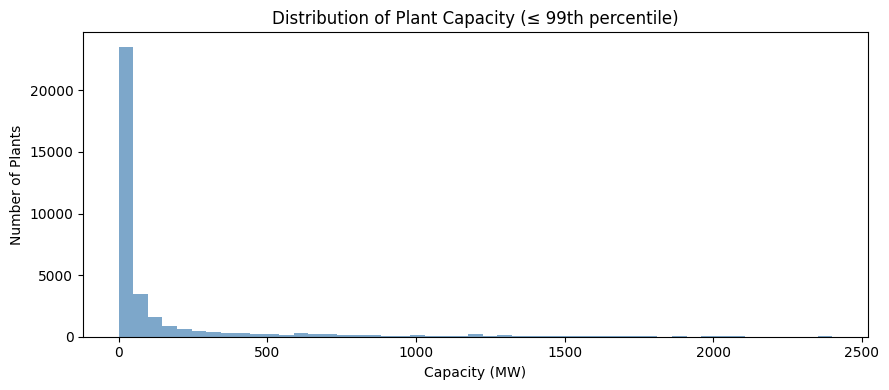

In [77]:
import matplotlib.pyplot as plt

# Get values and trim at the 99th percentile
vals = df["capacity_mw"].dropna().to_numpy()
upper = np.nanpercentile(vals, 99)

# Create bins from 0 up to the 99th percentile
bins = np.linspace(0, upper, 50)

# Plot histogram with custom bins
plt.figure(figsize=(9,4))
plt.hist(vals[vals <= upper], bins=bins, color="steelblue", alpha=0.7)
plt.title("Distribution of Plant Capacity (≤ 99th percentile)")
plt.xlabel("Capacity (MW)")
plt.ylabel("Number of Plants")
plt.tight_layout()
plt.show()
